# Dense NN with Categorical Embeddings

In this notebook, we are fitting a dense neural network (based on a multilayer-perceptron / MLP) using a pre-prepared training dataset from the Predict Future Sales competition.

One of the major challenges when fitting the dataset to an MLP-type Neural Network is deciding what to do with any categorical features. The discussion and approach below represents one of the possible answers to this problem.

Some very basic familiarity with the concepts of multilayer-perceptrons (MLPs) and Keras are assumed - the following are really useful resources should one wish to brush up:


<ul>
    <li><a href="https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53">What the hell is Perceptron</a></li>
    <li><a href="https://www.kindsonthegenius.com/blog/2018/01/basics-of-multilayer-perceptron-a-simple-explanation-of-multilayer-perceptron.html">Basics of Multilayer Perceptron</a></li>
    <li><a href="https://keras.io/getting-started/functional-api-guide/">Keras - Guide to the Functional API</a></li>
</ul>

Also, credit to the following excellent articles and their authors, who provided learning and inspiration for this notebook:

<ul>
    <li><a href="https://towardsdatascience.com/decoded-entity-embeddings-of-categorical-variables-in-neural-networks-1d2468311635">Entity Embeddings of Categorical Variables in Neural Networks</a></li>
    <li><a href="https://towardsdatascience.com/an-overview-of-categorical-input-handling-for-neural-networks-c172ba552dee">An Overview of Categorical Input Handling for Neural Networks</a></li>
    <li><a href="https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9">On learning embeddings for categorical data using Keras</a></li>
</ul>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Input, Reshape
import matplotlib.pyplot as plt

%matplotlib inline

pd.options.display.float_format = '{:.4f}'.format
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/nn-data/test_data_nn.pkl
/kaggle/input/nn-data/train_data_nn.pkl


In [2]:
train_data = pd.read_pickle('../input/nn-data/train_data_nn.pkl')
test_data = pd.read_pickle('../input/nn-data/test_data_nn.pkl')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349928 entries, 0 to 2349927
Data columns (total 29 columns):
date_block_num                     float16
item_id                            float16
shop_id                            float16
item_category_id                   float16
months_since_item_first_sale       float16
months_since_last_sale             float16
month                              float16
month_length                       float16
lag_1m_cum_item/shop_sales         float32
lag_6m_cum_item/shop_sales         float32
lag_12m_cum_item/shop_sales        float32
lag_1m_mean_item_sales             float32
lag_6m_mean_item_sales             float32
lag_12m_mean_item_sales            float32
lag_3m_mean_shop_sales             float32
lag_6m_mean_shop_sales             float32
lag_12m_mean_shop_sales            float32
lag_1m_mean_shop_cat/item_sales    float32
lag_1m_mean_cat/shop_sales         float32
lag_3m_mean_cat/shop_sales         float32
lag_6m_mean_cat/shop_sales 

# The Theory

<h2>General Data Types <small>(statistical data types that is....)</small> </h2>

Above, you can see the training dataset contains many examples (approx 3.75M) and has a relatively large number of features (29 including ID and target variable). The features include examples of each of the main types of statistical data:

<h4>Numerical:</h4>

 * <span style="color:darkblue">Discrete</span> - countable features that take only integer values, such as <code>month_length</code> or  <code>months_since_last_sale</code>
 * <span style="color:darkblue">Continuous</span> - measurable features that take a range of values and are measured / calculated rather than counted, for example <code>lag_1m_mean_sales</code> or <code>lag_3m_mean_cat_revenue</code>

<h4>Categorical:</h4>

 * <span style="color:darkblue">Nominal</span> - features that can't be represented numerically, other than to give them an arbitrary ID that has no numerical meaning. Examples are (pretty obviously anything suffixed with id) <code>item_id</code> or  <code>item_category_id</code>
 * <span style="color:darkblue">Ordinal</span> - discrete features that can be ordered, but are still categorical or can't be explained by counting only. A simple example would be education level (primary / secondary / university). Whilst debatable, it can be argued that <code>month</code> is an ordinal feature (particularly as it's distinguished from <code>date_block_num</code>). In this setting (retail sales), the different months have a significance beyond their numerical position in the year (given the holidays they contain for example), and so can't be explained by just counting them up and numbering them.
 
<h2>MLP Challenges</h2>

The categorical features in the dataset present a problem for a multilayer perceptron (MLP). Each node or "perceptron" in an MLP is activated based on the linear combination of the node's inputs multiplied by the (trainable) weights corresponding to each input, very similar in spirit to linear regression:

<br>

![IMG-20191206-163546.jpg](https://i.postimg.cc/T1DNBfb1/IMG-20191206-163546.jpg)

<br>

This presents two obvious problems where categorical data is concerned:
1. The model is simply unable to handle non-numerical input. So all categorical data must be converted into numerical data.
2. The categorical data should be **interpretable** by the model as numerical data.

As such, it's not good enough simply to convert your categories into an ordinal variable (i.e. an ID) and feed that into the MLP. The structure will assume a numeric relationship between all the inputs, and so **id 4** would be assumed to have a magnitude that is twice that of **id 2** which is, of course, nonsense.

<h2>The Traditional Solution</h2>

The traditional work-around for this issue is to use <bold>One Hot Encoding</bold>. This simply involves creating a new feature for each different category within your categorical feature, and assigning the new features the values 1 if they match the category and 0 if they don't. For example, from the following data:

<br>

<table>
  <tr>
    <th>name:</th>
    <th>animal</th>
    <th>age</th>
  </tr>
  <tr>
    <td>Fido</td>
    <td>Dog</td>
    <td>10</td>
  </tr>
  <tr>
    <td>Spanky</td>
    <td>Cat</td>
    <td>8</td>
  </tr>
  <tr>
    <td>Nibbles</td>
    <td>Rabbit</td>
    <td>2.5</td>
  </tr>
  <tr>
    <td>Jaws</td>
    <td>Dog</td>
    <td>4</td>
  </tr>
</table>

<br>

<text>.... the animal category could be converted via One Hot Encoding to:</text>

<br>

<table>
  <tr>
    <th>name:</th>
    <th>age</th>
    <th>Dog</th>
    <th>Cat</th>
    <th>Rabbit</th>
  </tr>
  <tr>
    <td>Fido</td>
    <td>10</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>Spanky</td>
    <td>8</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>Nibbles</td>
    <td>2.5</td>
    <td>0</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Jaws</td>
    <td>4</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
</table>

<br>

Simple! This approach does come with a couple of key drawbacks however:

1. When presented with a feature with several elements / several categorical features / both, it doesn't take long for your dataset to reach unmanageably large dimensions
2. Often categorical features are interrelated. One Hot Encoding treats all categories as independent of one another. Take for example the days of the week - Monday-Friday and Saturday/Sunday have particular shared relationships not captured by simply encoding them in separate features

The dimensionality issue is particularly stark in this case, as our dataset is already ~2.5M examples by 25+ features, 5 of which are purely categorical. Within these 5 categorical features are tens of thousands of individual distinct elements, and so it's simply not feasible to consider One Hot Encoding in this case (without dropping some of the categorical features outright).

Thankfully, there is a solution that addresses all of these issues:

<h2>Embedding Categorical Features</h2>

If you've read anything about natural language processing, you will certainly have encountered the concept of embeddings before. An embedding is an encoding of the properties of categorical information in a fixed-length numerical form. This is particularly useful in natural language processing as the meaning and semantics of a word or sentence can be represented numerically in a fixed-length vector.

An example could be an embedding of the words **King, Prince, Queen, Princess** as follows:

<div style="text-align:center"><code>King = [-1,1]</code></div>
<div style="text-align:center"><code>Prince = [-1,-1]</code></div>
<div style="text-align:center"><code>Queen = [1,1]</code></div>
<div style="text-align:center"><code>Princess = [1,-1]</code></div>

<br>

In this example, the first dimension encodes the **masculinity / femininity** of the word, and the second dimension the age attribute **young / old**. Of course, in reality much longer vectors are used and in such a way that it's not so easy to distinguish definite features.

This concept can be leveraged to interpret categorical data to be fed to an MLP. Embedding layers can be added for any categorical features in the dataset, which convert the data into a vector that is fed into the MLP input layer. The embedding layer itself is trainable as part of the neural network, and so learns the 'meaning' of the different categorical data as it trains.

<h2>Embedding Layer</h2>

An embedding layer is pretty simple. It can be thought of as a lookup table of weights that has the same number of rows as your output embedding vector, and the same number of columns as there are categories in your categorical feature. For example, if you had 10 different elements in your categorical feature, you could visualise your embedding layer like so:

<br>

![IMG-20191206-163111.jpg](https://i.postimg.cc/wMFbc7cK/IMG-20191206-163111.jpg)

<br>

This embedding layer would convert each sample in your categorical feature into a vector of length 5. As it trains, your network will then update the weights in the table to best "describe" each element of your categorical feature.

<h2>Adding Embedding Layers to an MLP</h2>

Embedding layers like the above can be added for each of the categorical features in your dataset. The values from the vector outputs of these embeddings can then be fed into a basic MLP alongside the numeric data in your dataset, which is fed straight into the MLP unchanged:

<br>

![IMG-20191206-164746.jpg](https://i.postimg.cc/NfbRYZxj/IMG-20191206-164746.jpg)

<br>

The whole network is then trained in forward / backward passes that begin and end at the embedding layers. By training the embedding layers, the network can learn the best embedding that represents the different features of the categorical variables.



# Basic Keras Example

Now let's get down to some business. You can pretty easily build a basic Neural Network with categorical feature embeddings using Keras. A simple example for a dataset with one categorical feature and 9 numerical features might look like this:

In [3]:
def build_basic_model():
    # Specify the number of different elements in the categorical feature and 
    # the length of the embedding vector these elements are going to be converted to.
    # This information is required when defining an embedding layer.
    elements_in_category = 10
    embedding_size = int(min(elements_in_category / 2, 50))

    # create an input for the categorical feature
    categorical_input = Input(shape=(1,))
    
    # create an input for the remaining numerical data
    numerical_input = Input(shape=(9,))    
    
    # crate an embedding layer for the categorical feature
    category_embedding = Embedding(elements_in_category, 
                                   embedding_size, 
                                   input_length=1)(categorical_input)
    category_embedding = Reshape(target_shape=(embedding_size,))(category_embedding)

    # concatenate the embedding values from the categorical input 
    # and the numerical inputs together
    inputs = Concatenate(axis=-1)([category_embedding, numerical_input])

    # create a basic 100 node MLP with a single node regression output
    dense_layer = Dense(100, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(inputs)
    output_layer = Dense(1, kernel_regularizer=regularizers.l2(0.01))(dense_layer)   

    # build the model
    model = keras.Model(inputs=[categorical_input, numerical_input], outputs=output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

<small><i><b>Note:</b> the model has to be defined using Keras' <a href="https://keras.io/getting-started/functional-api-guide/">Functional / Model class API</a>, rather than the more streamlined <a href="https://keras.io/getting-started/sequential-model-guide/">sequential model API</a> that some folk are more familiar with. This is simply because when using the sequential model, any layers added to the model are applied universally to the outputs of all preceding layers. It's not possible to apply an embedding layer to a selection of the input data using the sequential model - either you embed all your input data or none at all</i></small>

# Building a Model to Fit the Predict Future Sales Data

Now that we've seen a basic example we can create a model for the competition data. The training/test data used in this notebook has already been prepared beforehand with a number of engineered features, and has been scaled and shuffled to speed up the neural network training process. A bit of work is needed to create a dataset that the embedding model will be happy with.

<h2>Data Preparation</h2>

Firstly, the categorical features will need to be identified and given ordinal encodings for each individual element in each category (i.e. encoding each element with a number from 0 to the total number of elements):

In [4]:
from sklearn.preprocessing import OrdinalEncoder

cat_features = ['date_block_num', 'item_id', 'shop_id', 'item_category_id', 'months_since_item_first_sale',
                'months_since_last_sale', 'month', 'month_length']

train_test_cat_features = pd.concat([train_data[cat_features], test_data[cat_features]])

enc = OrdinalEncoder().fit(train_test_cat_features)

train_data_cat_features = pd.DataFrame(enc.transform(train_data[cat_features]),
                                       columns=cat_features)
test_data_cat_features = pd.DataFrame(enc.transform(test_data[cat_features]),
                                      columns=cat_features)

An important point to note: some of the features chosen might be thought of as traditional discrete numerical data, such as <code>months_since_item_first_sale</code>. Whilst this may be so, often values within these discrete features are not entirely independent of one another and can include some element of covariability, as more traditional categorical features might.

An example might be a particular period after an item is first sold, when items are typically reduced as a promotion - the months preceding / after the promotion period will be more closely associated with one another. By embedding these features, we can capture these additional associations if there are any (as they will then be represented by a vector of continuous values rather than an individual discrete value), at no loss (other than additional complexity) if they are indeed completely independent.

As a general rule of thumb, any discrete feature that has a relatively small range of values may well benefit from encoding, and so it's worth treating all such features as categorical in this setting.

All categorical features will then need to be fed into the model separately. The model accepts a list of inputs: an individual integer for each categorical feature, and a vector of the remaining numerical data. For example, a training example containing three categorical features and five numeric features might look like this:

<div style="text-align:center"><code><b>[5],[41],[3],[-0.6,1.1,0.1,-1.2,-0.8]</b></code></div>

<br>

Of course, the prepared dataset will contain multiple training examples - a vector for each categorical feature with a length equal to the number of training examples, and a matrix for the numerical data with dimensions (number of examples x number of numeric features):

In [5]:
# we will be using the last month of training data as a validation set to train the NN
val_mask = train_data_cat_features.date_block_num == (train_data_cat_features.date_block_num.max())

# Features that aren't to be included in the training data
# 'item_cnt_month' is the target and ID is not a descriptive feature
drop_features = ['item_cnt_month', 'ID']

# inputs to model need to come in the form of a list containing a (1,n) vector
# for each categorical variable in order, and a (n, n_continuous_features) matrix
# of the remaining continuous features
X_train = []

# this loops over the categorical features and creates an individual vector for
# each one, appending it to the input list
for cat in cat_features:
  X_train.append(np.array(train_data_cat_features[~val_mask][cat]).reshape(-1,1))

# the remaining continuous features are appended to the end of the list as a matrix
X_train.append(train_data[~val_mask].drop(drop_features + cat_features, axis=1).values)
y_train = train_data[~val_mask].item_cnt_month

X_val = []

for cat in cat_features:
  X_val.append(np.array(train_data_cat_features[val_mask][cat]).reshape(-1,1))

X_val.append(train_data[val_mask].drop(drop_features + cat_features, axis=1).values)
y_val = train_data[val_mask].item_cnt_month

X_test=[]

for cat in cat_features:
    X_test.append(np.array(test_data_cat_features[cat]).reshape(-1,1))

X_test.append(test_data.drop(cat_features, axis=1).values)

The following is an example of the first couple of data points in the training dataset (a tad messy looking but you get the idea):

In [6]:
train_examples_2 = []
for data in X_train:
  train_examples_2.append(data[:2])

train_examples_2

[array([[0.],
        [1.]]), array([[2829.],
        [ 576.]]), array([[30.],
        [24.]]), array([[28.],
        [16.]]), array([[23.],
        [ 2.]]), array([[5.],
        [0.]]), array([[11.],
        [ 0.]]), array([[2.],
        [2.]]), array([[ 0.        ,  0.        ,  0.        , -0.3333333 , -0.3837209 ,
         -0.3503185 , -0.49076572, -0.8107233 , -1.0361814 , -0.14814815,
         -0.26341057, -0.23555253, -0.2991169 , -0.31922275, -0.32580206,
         -0.02474844, -0.05221799,  0.38018858,  0.318096  ],
        [ 5.        ,  7.        ,  3.5       ,  5.8666663 ,  0.74418604,
          0.23566876,  2.969811  ,  2.6643963 ,  2.5122256 ,  6.962963  ,
          8.345599  ,  4.1375403 ,  2.2738938 ,  1.3659759 ,  0.93930066,
          6.5508337 ,  3.460384  ,  1.3085648 ,  0.25620696]],
       dtype=float32)]

<h2>Building the Model</h2>

With the data prepared we can now move onto the model. 

First, a function is defined to create the categorical embedding layers. The function accepts as input a list of the categorical feature names. Each embedding is given a length half that of the number of elements in a category, or of 50, whichever is lower. Each input and embedding layer is then saved in a dict that can be referred to when defining the model:

In [7]:
# prevents any conflicts with previously loaded models
tf.keras.backend.clear_session() 

In [8]:
def build_categorical_inputs(features):

    initial_inputs = {}
    cat_input_layers={}

    for feature in features:
        no_of_unique_cats  = train_test_cat_features[feature].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cats)/2), 50))
        categories  = no_of_unique_cats + 1

        initial_inputs[feature] = Input(shape=(1,))
        embedding_layer = Embedding(categories, 
                                    embedding_size,
                                    embeddings_regularizer=regularizers.l2(0.01),
                                    input_length=1)(initial_inputs[feature])
        cat_input_layers[feature] = Reshape(target_shape=(embedding_size,))(embedding_layer)

    return initial_inputs, cat_input_layers

The rest of the model can then be created. Structured in the same way as the basic model example, this model simply leverages the above function to create several categorical embeddings, and features a number of hidden layers to capture more information from the data:

In [9]:
def build_model():
  
    initial_inputs, input_layers = build_categorical_inputs(cat_features)

    no_of_num_features = len(train_data.columns) - len(cat_features) - len(drop_features)
    
    initial_inputs['numerical_features'] = Input(shape=(no_of_num_features,))
    input_layers['numerical_features'] = initial_inputs['numerical_features']

    inputs = Concatenate(axis=-1)([layer for layer in input_layers.values()])

    drop_1_out = Dropout(0.1)(inputs)
    dense_1_out = Dense(256, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_1_out)
    drop_2_out = Dropout(0.1)(dense_1_out)
    dense_2_out = Dense(125, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_2_out)
    drop_3_out = Dropout(0.1)(dense_2_out)
    dense_3_out = Dense(64, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_3_out)
    drop_4_out = Dropout(0.1)(dense_3_out)
    dense_4_out = Dense(32, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_4_out)
    final_out = Dense(1, kernel_regularizer=regularizers.l2(0.01))(dense_4_out)   

    model = keras.Model(inputs=[input for input in initial_inputs.values()], 
                        outputs=final_out)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

model = build_model()

The following summary describes the features of the model layer by layer. Note the trainable parameters for each categorical feature, which total the length of the output embedding multiplied by the number of elements in the category:

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

As a quick sanity check, we can have the model make untrained predictions on our training examples. Any issues when preparing the data or building the model will quickly become obvious:

In [11]:
train_examples_10 = []
for data in X_train:
  train_examples_10.append(data[:10])

example_result = model.predict(train_examples_10)
example_result

array([[ 0.01943396],
       [ 0.2637895 ],
       [-0.18221751],
       [ 0.06414639],
       [ 0.00714784],
       [ 0.09179152],
       [ 1.4761764 ],
       [ 0.08349843],
       [-0.03434511],
       [ 0.09465382]], dtype=float32)

Thankfully it doesn't seem like there are any problems. All that remains is to train the model and output the results of training:


# Training, Evaluation and Prediction

The rest of the process should speak for itself....

In [12]:
checkpoint_path = os.getcwd()
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# not particularly useful in the Kaggle Notebook environment 
# but can be really useful for training in other environments
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# create an early stopping callback 
# will stop training if the validation MSE hasn't improved in (patience) epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history = model.fit(X_train, y_train,
                    batch_size=1000,
                    epochs=30, 
                    validation_data =(X_val, y_val),
                    callbacks=[checkpoint, early_stop],
                    verbose=1)

Train on 2084656 samples, validate on 265272 samples
Epoch 1/30


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2083000/2084656 [============================>.] - ETA: 0s - loss: 6.4641 - mae: 0.3560 - mse: 1.1487
Epoch 00001: saving model to /kaggle/working
2084656/2084656 [==============================] - 39s 19us/sample - loss: 6.4637 - mae: 0.3560 - mse: 1.1491 - val_loss: 5.2589 - val_mae: 0.2846 - val_mse: 0.8577
Epoch 2/30
2084000/2084656 [============================>.] - ETA: 0s - loss: 4.8442 - mae: 0.3584 - mse: 1.0156
Epoch 00002: saving model to /kaggle/working
2084656/2084656 [==============================] - 37s 18us/sample - loss: 4.8441 - mae: 0.3584 - mse: 1.0157 - val_loss: 4.2079 - val_mae: 0.2849 - val_mse: 0.8419
Epoch 3/30
2084000/2084656 [============================>.] - ETA: 0s - loss: 4.0347 - mae: 0.3550 - mse: 0.9837
Epoch 00003: saving model to /kaggle/working
2084656/2084656 [==============================] - 38s 18us/sample - loss: 4.0348 - mae: 0.3550 - mse: 0.9839 - val_loss: 3.6229 - val_mae: 0.2744 - val_mse: 0.8385
Epoch 4/30
2082000/2084656 [==============

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('model_history.csv', index=False)
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,6.4637,0.3560,1.1491,5.2589,0.2846,0.8577,0
1,4.8441,0.3584,1.0157,4.2079,0.2849,0.8419,1
2,4.0348,0.3550,0.9839,3.6229,0.2744,0.8385,2
3,3.5521,0.3516,0.9664,3.2425,0.2670,0.8320,3
4,3.2288,0.3470,0.9556,2.9769,0.2667,0.8275,4
5,2.9846,0.3437,0.9384,2.7750,0.2641,0.8233,5
6,2.8085,0.3420,0.9371,2.6163,0.2665,0.8217,6
7,2.6496,0.3404,0.9271,2.4717,0.2647,0.8196,7
8,2.5032,0.3386,0.9194,2.3400,0.2592,0.8222,8
9,2.3754,0.3382,0.9165,2.2187,0.2579,0.8162,9


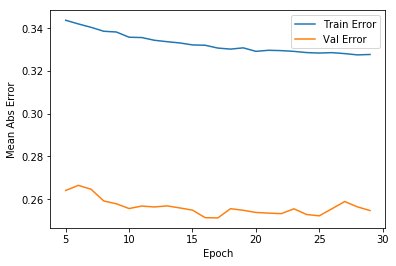

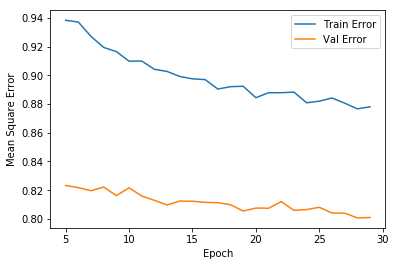

In [14]:
def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label='Val Error')  
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label='Val Error')
    plt.legend()
    plt.show()


plot_history(hist.iloc[5:])

In [15]:
model.evaluate(X_train, y_train)

2084656/2084656 [==============================] - 149s 71us/sample - loss: 1.2457 - mae: 0.3134 - mse: 0.8408


[1.2456912143221508, 0.3134427, 0.84081984]

In [16]:
predictions = model.predict(X_test).clip(0, 20)
submission = pd.DataFrame({
    "ID": test_data.index,
    'item_cnt_month': predictions.flatten()
})
submission.to_csv('model_output.csv', index=False)

and there we have it! A functioning neural network with categorical feature embeddings....

# Results and Final Thoughts

The model presented is just a basic example - the dataset used and the model's structure / parameterization / number of training epochs have been chosen for ease of explanation and to achieve some resonably quick results. As such, don't expect mind-blowing predictions in its current state. I would encourage anyone interested to fork this notebook, upload your own prepared dataset and have a play around. As is always the case with neural networks, there are a huge number of possible architectures and parameters to play around with. Possible interesting avenues include:

* adding / removing / widening / shortening  layers in the network
* adjusting the regularization layers / parameters (dropout / l2)
* adding new regularization parameters
* changing activation functions
* changing the gradient descent optimizer
* adjusting the learning rate and no of epochs
* etc, etc.....

With some tinkering, you'll find that the networks performance can quickly approach that of the aforementioned popular models. Neural networks like this also offer a huge amount of flexibility which can offer some really promising avenues for improving your scores. 

<b>Note: you can dramatically improve the training time of the model by increasing the batch size and utilizing a GPU session!</b>

In [17]:
import pandas as pd
item_categories = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")